---
# INFO-H600 - Computing Foundations of Data Sciences

## Team 14 : 

Roman Lešický, Theo Abraham, Kevin Straatman, Lara Hansen, Grégoire Van den Eynde and Nicolas Roux

Version of python : 3.11.14 | packaged by conda-forge 

---

# Library:

###### The download environment.txt is present within the Github repository of the project https://github.com/RomanLesicky/Data_Science_Project_INFO_H600

### How path's are handled in this project:

In [1]:
from pathlib import Path # We are using the pathlib library for our paths 

# The way the code works is that we first locate the project's root
project_root = Path.cwd().resolve()

# Then we make a variable which hall be used as our data directory path which is sued for everyone in this project 
# For steps 2 till 5 included.

data_dir = project_root / "data" 

# Simple print for as a sanity check
print("Project root:", project_root)
print("Data dir:", data_dir)

Project root: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600
Data dir: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data


### Rest of the library:

In [2]:
from pyspark.sql import SparkSession, functions 
import matplotlib.pyplot as plt

#! To be continued ofc 

---

# Overview of the project :

# `WIP`

---

# Task 1:

`TBD`

# DO NOT FORGET TO DO THE DOCUMENTATION in the `PDF`

### 1.0 Set-up of the SparkSession

In [3]:
# Int this cell we initialise a SparkSession, which can be reused.
# An important part of this code is that indicating to Spark to run all available CPU cores, for each task utilizing Spark.
# Therefore, the use of the code has been warned that when they are running cell which are Spark related this will utilize their whole CPU.
# The reason for doing this is that it gives us parallelism without needing a proper cluster
# Additionally, for larger file size we are allocating 16gb for the heap for the driver and executors (JVM), 200 of shuffles is reasonable and works for larger files 

spark = (SparkSession.builder.appName("MillionPlaylistProject").master("local[*]").config("spark.driver.memory", "16g")      
    .config("spark.executor.memory", "16g").config("spark.driver.maxResultSize", "4g").config("spark.sql.shuffle.partitions", "200").getOrCreate())

spark  # Just for postery we display the session 

### 1.1 Reading JSON slices into raw DataFrames using Spark

In [4]:
"""
This is an important part of the project which needs to be addressed. 

The question "How many slice files / slices do we want to read?" needs to be asked since this determined the trade-off between scalability and practical runtime.
Essentially, the answer to that question is having a sufficient amount of data that our metrics will be good whilst not calculating until forever. 

As a group we have decide to hardcode the value 5 for demonstration purposes, this means that we shall ony use mpd.slice.0 to 4999 so only about 5k playlists. 
The sole reason for this specific value is that it small enough to run very fast and yet demonstrate that the pipeline works. 
Additionally the use can adapt this number via the global variable `NUMBER_OF_SLICES`, but they shall keep in mind the that they are using all the cores of their CPU for this. 

That being said, for practical reasons which concern task's 3 and 4 (5 too) we shall use a dataset that contains 50 slices meaning 50 thousand playlists. 
This value does provides enough data to obtain stable aggregate statistics and similarity scores while keeping computation times manageable on a single machine.

Here we do not use a randomized method to chose the slices, since the data at hand is not ordered nor are we worried with a certain bias since we shall be using the 50k 
version for the actual metric determination. 

For context:

Running the 5k version uses only a couple of gb of ram, whilst using the 50k slice size takes about 14 gb of ram.

"""

# So this global variable is to be changed if one desires for a higher number of slices 
# This is very IMPORTANT this number must not be above 1000, since the database provides only a 1000 slices and could cause an Indexing error.
# If the user choses to put 1000 this represents the entire 32.1 Gb of data which is the full database.
NUMBER_OF_SLICES = 5

# This is the file path to the original Million Playlist Dataset to be used only in this Task, for the rest of the project the data_dir variable is meant to be used.
# This dataset will never be published to github since it's under the .gitignore file. 
data_dir_MGD_Original_Data = project_root / "data_Million_Playlist_Dataset" 

# Function to allow for numeric sorting and not str-related sorting, essentially this function will be used as the key parameter when using the sorted function

def slice_start_key_numeric(path: Path) -> int:
    """
    So, this function allows to extract the numeric "starting" index from filenames. 
    This allows to sort slices in the correct numeric order.
    """
    name = path.name # As an example, for mpd.slice.1000-1999.json
    
    # Here we will split to get the middle and starting string 
    the_numeric_value = name.split(".")[2] # this will split in function of "." so we get a list of ["mpd", "slice", "1000-1999", "json"] here we want 1000-1999 so [2]
    starting_string = the_numeric_value.split("-")[0] # here we split again and we also get a list but we only want the starting string so [0]
    
    # And we return the string into an integer to ger a proper numeric sorting 
    return int(starting_string) 

# Here we load all the "mpd.slice.*.json" type files which we sort in function of their numeric values  
# This creates a list of ordered Path object from all the MDP slice's.
all_slices_of_the_playlists = sorted(data_dir_MGD_Original_Data.glob("mpd.slice.*.json"),key=slice_start_key_numeric) # Here we do use the helper function slice_start_key_numeric as detailed above 

# We build a list of inputs paths for Spark, which we also use for printing the MPD files as a precaution 
input_paths = [str(path) for path in all_slices_of_the_playlists[:NUMBER_OF_SLICES]]

# The printing 
print(f"\nThe number of slices which was inputted by the user = {NUMBER_OF_SLICES}:")
for paths in input_paths:
    print("  ", paths)

# So, here we do start the actual PySpark pipeline where we read the selected slice files as a single Spark DataFrame.
# In here each of the files has the structure: {"info": {...}, "playlists": [ {...}, {...}, ... ]}
playlists_unedited_DataFrame = (spark.read.option("multiLine", True).json(input_paths))

# This means that we can directly parse nested multi-line JSON into a structured DataFrame, so we don’t need to write manual parsing code which would need to be done with Dask.


The number of slices which was inputted by the user = 5:
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.0-999.json
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.1000-1999.json
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.2000-2999.json
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.3000-3999.json
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.4000-4999.json


### 1.2 Flattening pipeline 

# Add more infos here cuz this is a bit meager 

> Note: Since our pipeline doesn't run on the entire 32.1 GB but rather on a sub-sample of a couple of slices (50 max) we rely on Spark's built-in schema inference. If we processed all 35 GB or ran on a cluster, we would define an explicit StructType schema to avoid an extra pass over the data.

In [5]:
"""
This second step of Task 1 consists in a flattening pipeline: we take the slice-level JSON files, extract all playlists, 
and then transform them into a final table with one row per (playlist, track).

From the 1.1 point we ended up with `playlists_unedited_DataFrame` which is a single dataframe "shape" according to how many `NUMBER_OF_SLICES`
the user has chosen. The data that is stored here corresponds to one row per JSON slice file.

Where each row has:
- an `info` struct, and

- a `playlists` array, where each element is a playlist with its own fields (pid, name, num_tracks, tracks, ...) 

For the remainder of the Tasks in this project it is much more convenient to work with "flat" tables rather 
than nested arrays and structs. Therefore we shall be making two table:

1) The first one named playlist-level table, which contains: 

   - one row per playlist
   - 9 columns: pid, name,collaborative,modified_atm,num_tracks, num_albums, num_followers, duration_ms and tracks 
   - This last `tracks` column still stores, for each playlist, the full array of its track entries. We will use it in the next step 
     to create one row per (playlist, track), and it also lets us easily reconstruct the original order of tracks if needed.


2) And a second one, named playlist-track table, which consists of:

   - one row per (playlist, track)
   - 15 columns: same information as the previous one, but we do not have tracks but tracks_pos, track_uri, track_name, artist_uri, artist_name,
                 album_uri, album_name, track_duration_ms

Essentially, the objective of these 2 tables is that we have a "normalized" outlook on the original data that we downloaded. Where:

- `playlists_flat_DataFrame` is a "playlist type" table which mainly contains information about the Playlist themselves 
                             from which specific Playlist metrics can be derived 
                             
- `playlist_track_DataFrame` in the same spirit but for tracks related information 

This helps us to:
- compute aggregate statistics in Task 2, 
- building track similarity from co-occurrences in playlists (Task 3),
- building playlist similarity (Task 4),
- and make a playlist continuation model (Task 5)

As briefly discussed in the markdown cell for section 1.2, we rely on Spark's built-in schema inference for the JSON input. The library inspects the JSON 
files and automatically infers field names and data types (string, long, array, struct, ...). We opted for this approach rather than defining an explicit 
JSON schema because we are not processing the full 32.1 GB of data, and therefore we do not strictly need very fine-grained control over every data type.

We are aware that if this this project needed all the data then a JSON scheme like `StructType` would have been necessary. Which would avoids an
extra pass of schema inference, making the job more robust against slight variations in the input.

In our particular setting, the inferred schema is stable across slices (even for a 50k-playlist subset), so we accept this trade-off between convenience and strictness.
"""

# Firstly we build the `playlists_flat_DataFrame` table: we explode the `playlists` array so that each playlist in each slice becomes its own row,
# and then we select only the playlist-level fields we need (pid, name, counts, duration, tracks).

playlists_DataFrame = playlists_unedited_DataFrame.select(
    functions.explode("playlists").alias("playlist"))

# From each `playlist` struct, we will only select the "playlist" related fields and `tracks` too.

playlists_flat_DataFrame = playlists_DataFrame.select(
    functions.col("playlist.pid").alias("pid"),                 # unique playlist id
    functions.col("playlist.name").alias("name"),               # playlist name
    functions.col("playlist.collaborative").alias("collaborative"),
    functions.col("playlist.modified_at").alias("modified_at"), # last modification timestamp
    functions.col("playlist.num_tracks").alias("num_tracks"),   # number of tracks in the playlist
    functions.col("playlist.num_albums").alias("num_albums"),   # number of distinct albums
    functions.col("playlist.num_followers").alias("num_followers"),
    functions.col("playlist.duration_ms").alias("duration_ms"), # total duration of the playlist
    functions.col("playlist.tracks").alias("tracks")            # still an array of track structs
)

# Secondly, we build the `playlist_track_DataFrame` table in a similar spirit: we explode the `tracks` array inside each playlist 
# and then flatten the nested `track` struct into explicit columns so that each row corresponds to a single (playlist, track) pair with all its metadata.

playlist_track_DataFrame = playlists_flat_DataFrame.select(
    functions.col("pid"),
    functions.col("name").alias("playlist_name"),
    functions.col("num_tracks"),
    functions.col("num_albums"),
    functions.col("num_followers"),
    functions.col("modified_at"),
    functions.col("duration_ms").alias("playlist_duration_ms"),
    functions.explode("tracks").alias("track")   # so here we explode the tracks array to make one row per track
)

# Here the `track` column is still a struct (pos, track_uri, track_name, artist, album, ...), so it needs to be flattened into individual columns, 
# so that each row is a fully explicit (playlist, track) record with all relevant information.

playlist_track_DataFrame = playlist_track_DataFrame.select(
    functions.col("pid"),
    functions.col("playlist_name"),
    functions.col("num_tracks"),
    functions.col("num_albums"),
    functions.col("num_followers"),
    functions.col("modified_at"),
    functions.col("playlist_duration_ms"),

    functions.col("track.pos").alias("track_pos"),             # position of the track in the playlist
    functions.col("track.track_uri").alias("track_uri"),       # Spotify track URI
    functions.col("track.track_name").alias("track_name"),     # track title
    functions.col("track.artist_uri").alias("artist_uri"),     # Spotify artist URI
    functions.col("track.artist_name").alias("artist_name"),   # artist name
    functions.col("track.album_uri").alias("album_uri"),       # Spotify album URI
    functions.col("track.album_name").alias("album_name"),     # album name
    functions.col("track.duration_ms").alias("track_duration_ms")  # duration of the specific track
)


#### 1.2.1 Scheme of  `playlist-level table` and `playlist–track table`:


In [6]:
print("Schema of playlist-level table:" + "\n")
playlists_flat_DataFrame.printSchema()

print("\nExample of 5 playlists:")
playlists_flat_DataFrame.show(5, truncate=False)

Schema of playlist-level table:

root
 |-- pid: long (nullable = true)
 |-- name: string (nullable = true)
 |-- collaborative: string (nullable = true)
 |-- modified_at: long (nullable = true)
 |-- num_tracks: long (nullable = true)
 |-- num_albums: long (nullable = true)
 |-- num_followers: long (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- tracks: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- album_name: string (nullable = true)
 |    |    |-- album_uri: string (nullable = true)
 |    |    |-- artist_name: string (nullable = true)
 |    |    |-- artist_uri: string (nullable = true)
 |    |    |-- duration_ms: long (nullable = true)
 |    |    |-- pos: long (nullable = true)
 |    |    |-- track_name: string (nullable = true)
 |    |    |-- track_uri: string (nullable = true)


Example of 5 playlists:
+----+--------+-------------+-----------+----------+----------+-------------+-----------+--------------------------------------

In [7]:
print("\nSchema of playlist-track table:" + "\n")
playlist_track_DataFrame.printSchema()

print("\nExample of 5 playlist-track rows:")
playlist_track_DataFrame.show(5, truncate=False)


Schema of playlist-track table:

root
 |-- pid: long (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- num_tracks: long (nullable = true)
 |-- num_albums: long (nullable = true)
 |-- num_followers: long (nullable = true)
 |-- modified_at: long (nullable = true)
 |-- playlist_duration_ms: long (nullable = true)
 |-- track_pos: long (nullable = true)
 |-- track_uri: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- artist_uri: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- album_uri: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- track_duration_ms: long (nullable = true)


Example of 5 playlist-track rows:
+----+-------------+----------+----------+-------------+-----------+--------------------+---------+------------------------------------+----------------------------+-------------------------------------+----------------------------+------------------------------------+---------------------------

### 1.3 Saving flattened DataFrames locally 

`To not run if one doesn't want to locally save the dataframes`

Additionally, to make this cell of code work the user needs to have winutils.exe and hadoop.dll installed locally. This can be found on this github page: 

- https://github.com/cdarlint/winutils

The version which was used for this project was hadoop-3.3.6.

In [6]:
"""
This third sub-part of Task 1 is about saving the flattened DataFrames for later Tasks so that we do not have to 
re-do the whole Step 1 pipeline more than once. This pipeline is very swift for the 5k example but it gets more and more 
heavy when increasing `NUMBER_OF_SLICES`.
"""

# NUMBER_OF_SLICES is defined in Section 1.1

# Here we have a very simple if/else code to decide on the folder's name based on NUMBER_OF_SLICES
if NUMBER_OF_SLICES >= 1000:  # if the user inputted 1000 then that corresponds to the full playlist dataset
    folder_name = "Full_Playlist"
else:  # otherwise we add that specific number as part of the folder name
    folder_name = f"{NUMBER_OF_SLICES}k_Playlists"

# Here we define the correct path
post_task1_dir = project_root / "data_post_Task_1" / folder_name

# Here we use mkdir to make it
post_task1_dir.mkdir(parents=True, exist_ok=True)

# Here is where we save the DataFrames produced in sections 1.1 and 1.2.
# For the playlist-level table, we drop the `tracks` array column to keep only playlist metadata.
# This needs to be done to safely save larger files such as 50k otherwise the code keeps crashing, crucially dropping the task 
# isn't the worst idea since in the playlist related table we do not need these information since they are all track related. 
# And finally all track-level information is already stored explicitly in `playlist_track_DataFrame`, which we also save.

playlists_flat_out = post_task1_dir / "playlists_flat"
playlist_track_out = post_task1_dir / "playlist_track"

# Drop the heavy `tracks` array before writing to avoid OutOfMemory errors for larger NUMBER_OF_SLICES
playlists_flat_to_save = playlists_flat_DataFrame.drop("tracks")

playlists_flat_to_save.write.mode("overwrite").parquet(str(playlists_flat_out))
playlist_track_DataFrame.write.mode("overwrite").parquet(str(playlist_track_out))
# We are in overwrite mode so each time this code cell is run it overwrites what is already present,
# so the user should be cautious.

# Just to make things very clear 
print("\nSaved playlist tables to:")
print(playlists_flat_out)
print(playlist_track_out)



Saved playlist tables to:
C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_post_Task_1\5k_Playlists\playlists_flat
C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_post_Task_1\5k_Playlists\playlist_track


----

# Task 2:

# Do the whole pipeline for 5k and 50k to see if there are any differences !!!

### 2.0 Loading a spark session:

Since the `Spark` session from Step 1 is to loaded only for that specific step we need to redefine the spark session here:

In [3]:
spark = (SparkSession.builder.appName("MillionPlaylistProject_Tasks2to5").master("local[*]").getOrCreate())

# Again we are using all cores of the CPU but are not allocating as much memory so this should be relatively safe to run resource-wise.

### 2.1 Loading processed data from Task 1:

In [4]:
# data_dir is defined in the Library (top section) of this Notebook  

processed_dir = data_dir / "5k_Playlists"

# Defining the paths to the two tables that we will be using 
playlists_flat_path = processed_dir / "playlists_flat"
playlist_track_path = processed_dir / "playlist_track"  

# Just for posterity to print that where everything is 
print("playlists_flat_path:", playlists_flat_path)
print("playlist_track_path:", playlist_track_path)

# Loading DataFrames that were created using spark.read (which is the reason why we need the SparkSession) 
playlists_flat_DataFrame = spark.read.parquet(str(playlists_flat_path))
playlist_track_DataFrame = spark.read.parquet(str(playlist_track_path))

# Some very basic information just to be sure that we loaded this correctly 
print("\nNumber of playlists:", playlists_flat_DataFrame.count())
print("Number of (playlist, track) rows:", playlist_track_DataFrame.count())


playlists_flat_path: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data\5k_Playlists\playlists_flat
playlist_track_path: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data\5k_Playlists\playlist_track

Number of playlists: 5000
Number of (playlist, track) rows: 334487


#### `50k_Playlists`

In [5]:
# The precise path where the 50k data is stored is within the data_post_Task_1 folder.
# Here we are using project_root which is also is defined in the Library (top section) of this Notebook  

data_dir_for_50k = project_root / "data_post_Task_1" / "50k_Playlists"

# Same principal as the cell above 
playlists_flat_path = data_dir_for_50k / "playlists_flat"
playlist_track_path = data_dir_for_50k / "playlist_track"  

print("playlists_flat_path:", playlists_flat_path)
print("playlist_track_path:", playlist_track_path)

playlists_flat_DataFrame_50k = spark.read.parquet(str(playlists_flat_path))
playlist_track_DataFrame_50k = spark.read.parquet(str(playlist_track_path))

print("\nNumber of playlists:", playlists_flat_DataFrame.count())
print("Number of (playlist, track) rows:", playlist_track_DataFrame.count())


playlists_flat_path: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_post_Task_1\50k_Playlists\playlists_flat
playlist_track_path: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_post_Task_1\50k_Playlists\playlist_track

Number of playlists: 5000
Number of (playlist, track) rows: 334487


Plan I guess:

2.2 Size and unique values ?

2.3 Basic visualisation of general variables 

-> so like top 10 artistis 
-> year distribution (since we have data from 2010 till 2017)

2.4 Stats and Graphics for Tracks (for Task 3)

-> singletong 

2.5 Stats and Graphics for Playlist (for Task 4)

-> playlist artistist diversity 




### 2.2 Basic size and cardinaliteis 

In [6]:


# ---- 5k subset ----
num_playlists_5k = playlists_flat_DataFrame.count()
num_rows_5k = playlist_track_DataFrame.count()
num_unique_tracks_5k = playlist_track_DataFrame.select("track_uri").distinct().count()
num_unique_artists_5k = playlist_track_DataFrame.select("artist_uri").distinct().count()
num_unique_albums_5k = playlist_track_DataFrame.select("album_uri").distinct().count()

print("\n[5k subset]")
print("Number of playlists:", num_playlists_5k)
print("Number of (playlist, track) rows:", num_rows_5k)
print("Number of unique tracks:", num_unique_tracks_5k)
print("Number of unique artists:", num_unique_artists_5k)
print("Number of unique albums:", num_unique_albums_5k)

# ---- 50k subset ----
num_playlists_50k = playlists_flat_DataFrame_50k.count()
num_rows_50k = playlist_track_DataFrame_50k.count()
num_unique_tracks_50k = playlist_track_DataFrame_50k.select("track_uri").distinct().count()
num_unique_artists_50k = playlist_track_DataFrame_50k.select("artist_uri").distinct().count()
num_unique_albums_50k = playlist_track_DataFrame_50k.select("album_uri").distinct().count()

print("\n[50k subset]")
print("Number of playlists:", num_playlists_50k)
print("Number of (playlist, track) rows:", num_rows_50k)
print("Number of unique tracks:", num_unique_tracks_50k)
print("Number of unique artists:", num_unique_artists_50k)
print("Number of unique albums:", num_unique_albums_50k)



[5k subset]
Number of playlists: 5000
Number of (playlist, track) rows: 334487
Number of unique tracks: 108870
Number of unique artists: 25127
Number of unique albums: 54868

[50k subset]
Number of playlists: 50000
Number of (playlist, track) rows: 3344374
Number of unique tracks: 461880
Number of unique artists: 80483
Number of unique albums: 195600


### 2.2 Other alternative 

In [9]:
from pyspark.sql import functions as F

print("--- Global Statistics (50k Slice) ---")

# We calculate the number of unique tracks, artists, and albums
# We use the URI columns as they are unique identifiers (names can be duplicates, e.g., two songs named "Hello")
global_stats = playlist_track_DataFrame_50k.select(
    F.countDistinct("track_uri").alias("unique_tracks"),
    F.countDistinct("artist_uri").alias("unique_artists"),
    F.countDistinct("album_uri").alias("unique_albums")
).collect()[0]

print(f"Total Unique Tracks: {global_stats['unique_tracks']:,}")
print(f"Total Unique Artists: {global_stats['unique_artists']:,}")
print(f"Total Unique Albums:  {global_stats['unique_albums']:,}")

# We also calculate the sparsity/density: Average number of tracks per playlist
# We can get this quickly from the flat playlist dataframe
avg_len = playlists_flat_DataFrame_50k.select(F.avg("num_tracks")).first()[0]
print(f"Average Tracks per Playlist: {avg_len:.2f}")

--- Global Statistics (50k Slice) ---
Total Unique Tracks: 461,880
Total Unique Artists: 80,483
Total Unique Albums:  195,600
Average Tracks per Playlist: 66.89


### 2.2 more different variant 

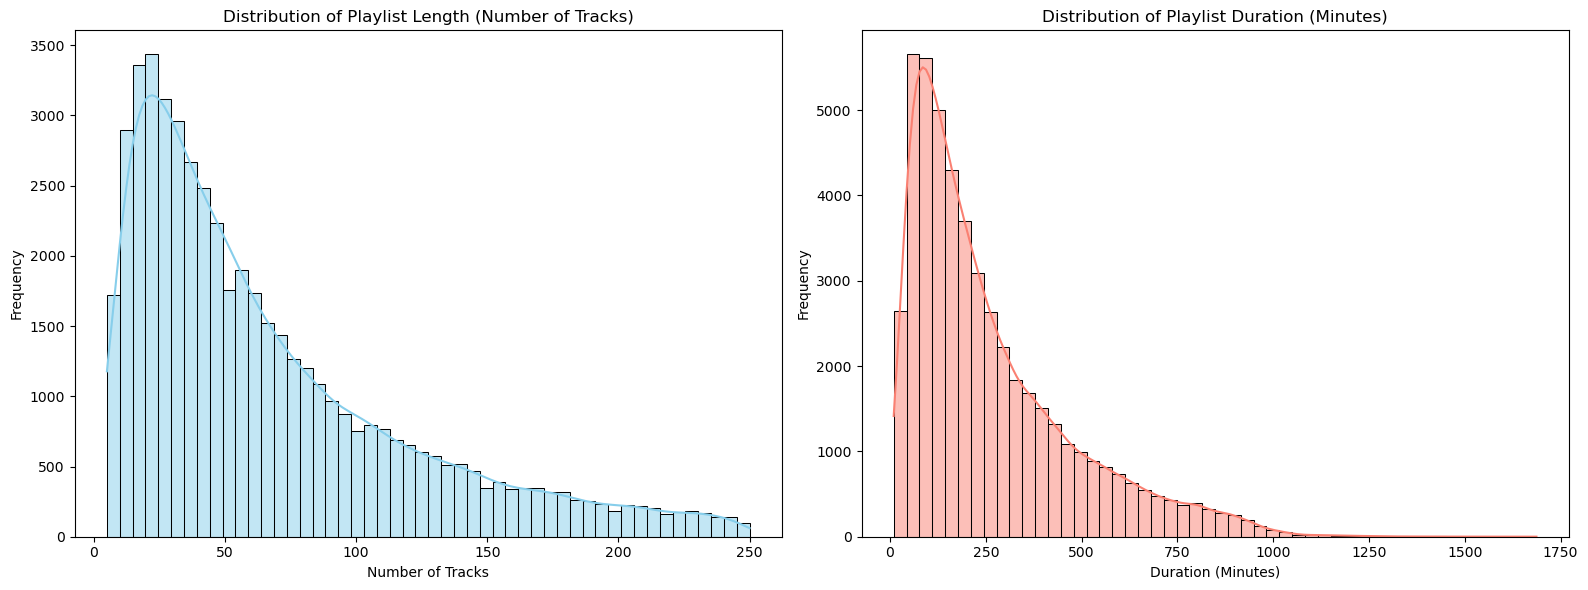

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Extract the relevant numeric columns
# We only need 'num_tracks' and 'duration_ms' for this visualization
dist_data = playlists_flat_DataFrame_50k.select("num_tracks", "duration_ms").toPandas()

# 2. Convert duration from ms to minutes
dist_data["duration_min"] = dist_data["duration_ms"] / 60000

# 3. Plotting
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogram for Number of Tracks
sns.histplot(dist_data["num_tracks"], bins=50, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title("Distribution of Playlist Length (Number of Tracks)")
ax[0].set_xlabel("Number of Tracks")
ax[0].set_ylabel("Frequency")

# Histogram for Duration
sns.histplot(dist_data["duration_min"], bins=50, kde=True, ax=ax[1], color='salmon')
ax[1].set_title("Distribution of Playlist Duration (Minutes)")
ax[1].set_xlabel("Duration (Minutes)")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### 2.3 Playlist length & duration (how long are playlists?)

In [7]:
# Add duration in minutes for easier interpretation
playlists_50k_with_duration = playlists_flat_DataFrame_50k.withColumn(
    "duration_min",
    functions.col("duration_ms") / (1000 * 60.0)
)

# Summary statistics for number of tracks and duration
print("=== Playlist length and duration statistics (50k subset) ===")
playlists_50k_with_duration.select("num_tracks", "duration_min") \
    .summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max") \
    .show()

# Build length buckets
playlists_50k_with_buckets = playlists_50k_with_duration.withColumn(
    "length_bucket",
    functions.when(functions.col("num_tracks") < 20, "<20 tracks")
             .when((functions.col("num_tracks") >= 20) & (functions.col("num_tracks") < 50), "20–49 tracks")
             .when((functions.col("num_tracks") >= 50) & (functions.col("num_tracks") < 100), "50–99 tracks")
             .otherwise("≥100 tracks")
)

length_distribution_50k = (
    playlists_50k_with_buckets
    .groupBy("length_bucket")
    .agg(functions.count("*").alias("num_playlists"))
)

# Compute percentages
length_distribution_50k = length_distribution_50k.withColumn(
    "percentage",
    functions.col("num_playlists") / functions.lit(num_playlists_50k) * 100.0
)

print("=== Distribution of playlist sizes (50k subset) ===")
length_distribution_50k.orderBy("length_bucket").show(truncate=False)


=== Playlist length and duration statistics (50k subset) ===
+-------+------------------+------------------+
|summary|        num_tracks|      duration_min|
+-------+------------------+------------------+
|  count|             50000|             50000|
|   mean|          66.88748|261.58401041366665|
| stddev|53.792405892544295|214.33708849864695|
|    min|                 5|            9.5181|
|    25%|                26|         101.71805|
|    50%|                50|          193.2392|
|    75%|                92|360.78858333333335|
|    max|               250|        1686.87895|
+-------+------------------+------------------+

=== Distribution of playlist sizes (50k subset) ===
+-------------+-------------+----------+
|length_bucket|num_playlists|percentage|
+-------------+-------------+----------+
|20–49 tracks |16892        |33.784    |
|50–99 tracks |13907        |27.814    |
|<20 tracks   |7974         |15.948    |
|≥100 tracks  |11227        |22.454    |
+-------------+--------

### 2.4 Diversity per playlist: how many different artists/albums?

In [6]:
print("=== Diversity of artists and albums per playlist (50k subset) ===")

artists_albums_per_playlist_50k = (
    playlist_track_DataFrame_50k
    .groupBy("pid")
    .agg(
        functions.countDistinct("artist_uri").alias("num_unique_artists"),
        functions.countDistinct("album_uri").alias("num_unique_albums")
    )
)

artists_albums_per_playlist_50k.select(
    "num_unique_artists",
    "num_unique_albums"
).summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()


=== Diversity of artists and albums per playlist (50k subset) ===
+-------+------------------+------------------+
|summary|num_unique_artists| num_unique_albums|
+-------+------------------+------------------+
|  count|             50000|             50000|
|   mean|          38.24012|          49.92954|
| stddev|30.268048920954744|39.970729897931214|
|    min|                 3|                 2|
|    25%|                16|                20|
|    50%|                30|                38|
|    75%|                52|                68|
|    max|               212|               242|
+-------+------------------+------------------+



### 2.5 Popular tracks & artists (how skewed is popularity?)

In [7]:
print("=== Track popularity (50k subset) ===")

track_popularity_50k = (
    playlist_track_DataFrame_50k
    .groupBy("track_uri", "track_name", "artist_name")
    .agg(functions.countDistinct("pid").alias("num_playlists"))
    .orderBy(functions.col("num_playlists").desc())
)

# Top 10 tracks by number of playlists
track_popularity_50k.show(10, truncate=False)

# Bucket distribution of popularity
track_popularity_buckets_50k = (
    track_popularity_50k
    .withColumn(
        "popularity_bucket",
        functions.when(functions.col("num_playlists") == 1, "1 playlist")
                 .when(functions.col("num_playlists") <= 5, "2–5 playlists")
                 .when(functions.col("num_playlists") <= 20, "6–20 playlists")
                 .otherwise(">20 playlists")
    )
    .groupBy("popularity_bucket")
    .agg(functions.count("*").alias("num_tracks"))
)

track_popularity_buckets_50k = track_popularity_buckets_50k.withColumn(
    "percentage",
    functions.col("num_tracks") / functions.lit(num_unique_tracks_50k) * 100.0
)

print("=== Distribution of track popularity (50k subset) ===")
track_popularity_buckets_50k.orderBy("popularity_bucket").show(truncate=False)

# ---- Artist popularity ----
print("=== Artist popularity (50k subset) ===")

artist_popularity_50k = (
    playlist_track_DataFrame_50k
    .groupBy("artist_uri", "artist_name")
    .agg(functions.countDistinct("pid").alias("num_playlists"))
    .orderBy(functions.col("num_playlists").desc())
)

artist_popularity_50k.show(10, truncate=False)


=== Track popularity (50k subset) ===
+------------------------------------+-----------------------------------+----------------+-------------+
|track_uri                           |track_name                         |artist_name     |num_playlists|
+------------------------------------+-----------------------------------+----------------+-------------+
|spotify:track:7KXjTSCq5nL1LoYtL7XAwS|HUMBLE.                            |Kendrick Lamar  |2183         |
|spotify:track:7BKLCZ1jbUBVqRi2FVlTVw|Closer                             |The Chainsmokers|2041         |
|spotify:track:1xznGGDReH1oQq0xzbwXa3|One Dance                          |Drake           |1999         |
|spotify:track:7yyRTcZmCiyzzJlNzGC9Ol|Broccoli (feat. Lil Yachty)        |DRAM            |1949         |
|spotify:track:3a1lNhkSLSkpJE4MSHpDu9|Congratulations                    |Post Malone     |1883         |
|spotify:track:5hTpBe8h35rJ67eAWHQsJx|Caroline                           |Aminé           |1746         |
|spotify

NameError: name 'num_unique_tracks_50k' is not defined

### 2.5 more alternative 

C:\Users\roman\AppData\Local\Temp\ipykernel_34352\3042456413.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="artist_name", data=top_artists, ax=ax[0], palette="viridis")
C:\Users\roman\AppData\Local\Temp\ipykernel_34352\3042456413.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="label", data=top_tracks, ax=ax[1], palette="magma")


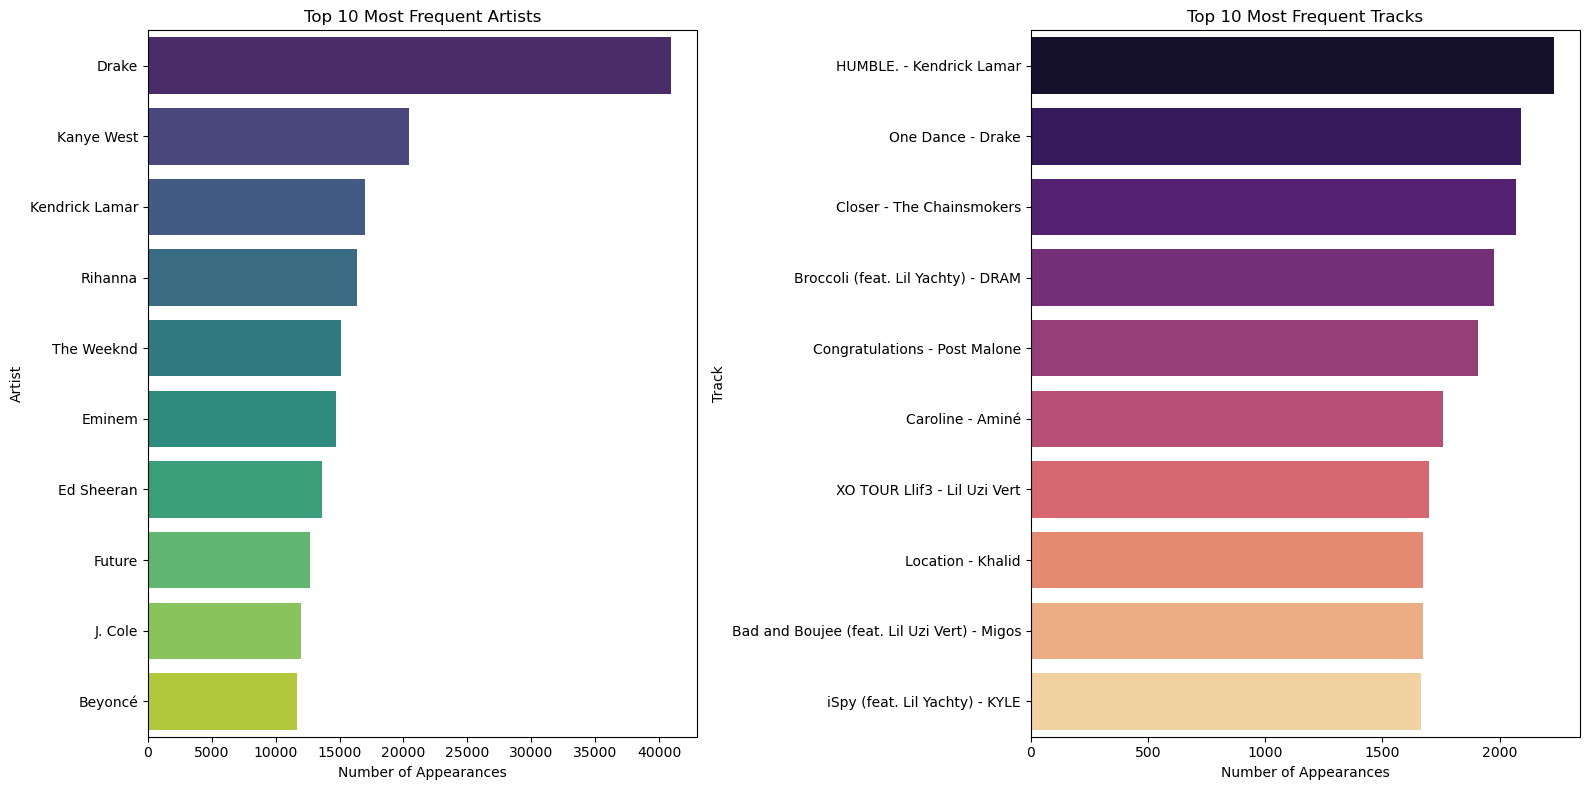

Top 10 Artists:
       artist_name  count
0           Drake  40919
1      Kanye West  20417
2  Kendrick Lamar  16987
3         Rihanna  16404
4      The Weeknd  15140
5          Eminem  14731
6      Ed Sheeran  13648
7          Future  12677
8         J. Cole  11976
9         Beyoncé  11701

Top 10 Tracks:
                             track_name       artist_name  count
0                              HUMBLE.    Kendrick Lamar   2231
1                            One Dance             Drake   2090
2                               Closer  The Chainsmokers   2070
3          Broccoli (feat. Lil Yachty)              DRAM   1974
4                      Congratulations       Post Malone   1908
5                             Caroline             Aminé   1759
6                        XO TOUR Llif3      Lil Uzi Vert   1700
7                             Location            Khalid   1674
8  Bad and Boujee (feat. Lil Uzi Vert)             Migos   1672
9              iSpy (feat. Lil Yachty)             

In [11]:
# --- Top 10 Popular Artists ---
top_artists = playlist_track_DataFrame_50k.groupBy("artist_name") \
    .count() \
    .orderBy(F.col("count").desc()) \
    .limit(10) \
    .toPandas()

# --- Top 10 Popular Tracks ---
top_tracks = playlist_track_DataFrame_50k.groupBy("track_name", "artist_name") \
    .count() \
    .orderBy(F.col("count").desc()) \
    .limit(10) \
    .toPandas()

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Bar Plot for Artists
sns.barplot(x="count", y="artist_name", data=top_artists, ax=ax[0], palette="viridis")
ax[0].set_title("Top 10 Most Frequent Artists")
ax[0].set_xlabel("Number of Appearances")
ax[0].set_ylabel("Artist")

# Bar Plot for Tracks
# We create a label "Track - Artist" for clarity
top_tracks["label"] = top_tracks["track_name"] + " - " + top_tracks["artist_name"]
sns.barplot(x="count", y="label", data=top_tracks, ax=ax[1], palette="magma")
ax[1].set_title("Top 10 Most Frequent Tracks")
ax[1].set_xlabel("Number of Appearances")
ax[1].set_ylabel("Track")

plt.tight_layout()
plt.show()

# Print the actual tables for the report
print("Top 10 Artists:\n", top_artists[["artist_name", "count"]])
print("\nTop 10 Tracks:\n", top_tracks[["track_name", "artist_name", "count"]])

### 2.6 Temporal distribution (when were playlists last modified?)

In [8]:
print("=== Temporal distribution of playlists (50k subset) ===")

playlists_50k_with_date = playlists_flat_DataFrame_50k.withColumn(
    "modified_date",
    functions.to_date(functions.from_unixtime("modified_at"))
)

playlists_per_year_50k = (
    playlists_50k_with_date
    .groupBy(functions.year("modified_date").alias("year"))
    .agg(functions.count("*").alias("num_playlists"))
    .orderBy("year")
)

playlists_per_year_50k.show()


=== Temporal distribution of playlists (50k subset) ===
+----+-------------+
|year|num_playlists|
+----+-------------+
|2011|           25|
|2012|          116|
|2013|         1788|
|2014|         3184|
|2015|         5517|
|2016|        10560|
|2017|        28810|
+----+-------------+



### 2.7 Apparently interresting things for later on tasks 


In [13]:
from pyspark.sql import functions as F

# --- Metric 1: Track "Singletons" (For Task 3) ---
# Count how many playlists every track appears in
track_counts = playlist_track_DataFrame_50k.groupBy("track_uri").count()

# Count how many tracks appear EXACTLY once
total_unique_tracks = track_counts.count()
singleton_tracks = track_counts.filter(F.col("count") == 1).count()

print(f"--- Task 3 Justification ---")
print(f"Total Unique Tracks: {total_unique_tracks}")
print(f"Tracks appearing only once: {singleton_tracks}")
print(f"Singleton Percentage: {(singleton_tracks/total_unique_tracks)*100:.2f}%")
print("Interpretation: Collaborative filtering will fail for this % of tracks.\n")


# --- Metric 2: Playlist Artist Diversity (For Task 4) ---
# For each playlist, count total tracks and unique artists
diversity_df = playlist_track_DataFrame_50k.groupBy("pid").agg(
    F.count("track_uri").alias("n_tracks"),
    F.countDistinct("artist_uri").alias("n_artists")
)

# Calculate ratio (Unique Artists / Total Tracks)
diversity_df = diversity_df.withColumn("ratio", F.col("n_artists") / F.col("n_tracks"))
avg_diversity = diversity_df.select(F.avg("ratio")).first()[0]

print(f"--- Task 4 Justification ---")
print(f"Average Artist Diversity Ratio: {avg_diversity:.4f}")
print("Interpretation: 1.0 means extremely diverse; close to 0 means single-artist playlists.\n")


# --- Metric 3: Matrix Sparsity (For Scale) ---
n_playlists = playlists_flat_DataFrame_50k.count()
n_entries = playlist_track_DataFrame_50k.count() # The number of rows in the exploded table

# Sparsity Formula
sparsity = 1 - (n_entries / (n_playlists * total_unique_tracks))

print(f"--- General Scalability ---")
print(f"Matrix Sparsity: {sparsity:.8f}")
print("Interpretation: The matrix is almost entirely empty, justifying sparse data approaches.")

--- Task 3 Justification ---
Total Unique Tracks: 461880
Tracks appearing only once: 266344
Singleton Percentage: 57.67%
Interpretation: Collaborative filtering will fail for this % of tracks.

--- Task 4 Justification ---
Average Artist Diversity Ratio: 0.6406
Interpretation: 1.0 means extremely diverse; close to 0 means single-artist playlists.

--- General Scalability ---
Matrix Sparsity: 0.99985518
Interpretation: The matrix is almost entirely empty, justifying sparse data approaches.


---

# Task 3:

## Please load the `2.0 and 2.1 Loading processed data from Task 1:` and keep using `playlists_flat_DataFrame` and `playlist_track_DataFrame`

If you are not able to load the 50k data that is normal and y'all should ignore it as discussed in the Whatsapp message, focus on the 5k which should work if not (╯°□°）╯︵┻━┻

# This way everything is standardized  

---

# Task 4:

## Please load the `2.0 and 2.1 Loading processed data from Task 1:` and keep using `playlists_flat_DataFrame` and `playlist_track_DataFrame`

If you are not able to load the 50k data that is normal and y'all should ignore it as discussed in the Whatsapp message, focus on the 5k which should work if not (╯°□°）╯︵┻━┻

# This way everything is standardized  

---

# Task 5:

## Please load the `2.0 and 2.1 Loading processed data from Task 1:` and keep using `playlists_flat_DataFrame` and `playlist_track_DataFrame`

If you are not able to load the 50k data that is normal and y'all should ignore it as discussed in the Whatsapp message, focus on the 5k which should work if not (╯°□°）╯︵┻━┻

# This way everything is standardized  

---

# Bibliography: 

It could be nice to get a reference for the Similarity part and justifying it using a paper, this is just an idea tho 
